# Probabilistic Graphical Models - Homework 2
Lucas Elbert

## 1 Classification - K-Means and the EM-Algorithm

We consider a diagonal multivariate Gaussian mixture model with $K$ components and parameters $\{p_k,\mu_k,D_k | 1 \leq k \leq K\}$. $Z_i$ models the component affiliation of datapoint $X_i$ with $P(Z_i=k)=p_k$ and $X_i | Z_i = k \sim \mathcal{N}(\mu_k,D_k)$.

### 1.3
Implementation of the EM algorithm

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

def random_params(X,K):
    p = np.random.uniform(size=K)
    p /= np.sum(p)
    # initialize the means as random x's:
    m = np.zeros(shape=(K,X.shape[1]))
    rand_indices = random.sample(range(0,X.shape[0]),K)
    for i in range(K):
        m[i] = X[rand_indices[i]]
    D = np.array([np.diag(np.random.uniform(0,1,size=X.shape[1])) for i in range(K)])
    return p,m,D

# M-step
def update_parameters(q, X, mode='diagonal'):
    dim = X.shape[1]
    K = q.shape[1]
    
    # for p_k sum over all x's the probability that it belongs to cluster k
    p = q.sum(axis=0)
    p /= p.sum()
    
    # for m_k build an weighted average of all x's,
    # weights according to the probability to belong to the cluster k
    # m is a k,dim matrix
    m = np.matmul(q.transpose(),X)
    for k in range(K):
        m[k] /= q[:,k].sum()
    
    # The covariance matrices are also estimated on a point-by-point basis
    # weighted according to the cluster belonging probabilities
    D = np.zeros(shape=(K,dim,dim))
    for k in range(K):
        for i in range(X.shape[0]):
            distance = m[k]-X[i]
            if mode == 'diagonal':
                D[k] += q[i,k]*np.diag([d*d for d in distance])
            elif mode == 'full':
                D[k] += q[i,k]*np.matmul(distance.reshape(dim,1),distance.reshape(1,dim))
            else:
                return 'unexpected mode'
        D[k] /= q[:,k].sum()
    
    return p,m,D
    
# E-step
def hidden_variable_probs(X, p, m, D):
    # Compute the marginal for the hidden variables
    K = len(p)
    q = np.zeros(shape=(X.shape[0],K))
    for i in range(X.shape[0]):
        for k in range(K):
            q[i,k] = multivariate_normal.pdf(X[i],m[k],D[k])*p[k]
        q[i,:] /= q[i,:].sum()
    return q

def EM(X, K, mode='diagonal',iterations=100):
    """ Implements the EM algorithm for multivariate Gaussian mixtures with K components """
    p, m, D = random_params(X,K)
    n = X.shape[0]
    for i in range(iterations):    
        # E-step
        # compute hidden variable probabilities (q(z))
        # q is a n,K matrix where n is the number of datapoints
        q = hidden_variable_probs(X,p,m,D)
        # M-Step
        # Update the parameters according to the formulas with the new hidden var estimates
        # (Maximizes the lowerbound loglikelihood)
        p, m, D = update_parameters(q,X,mode)
    return p,m,D

K-means implementation

In [3]:
import random

def KMeans(X,K,iterations=100):
    dim = X.shape[1]
    m = np.zeros(shape=(K,dim))
    
    # initialize the means as random x's:
    rand_indices = random.sample(range(0,X.shape[0]),K)
    for i in range(K):
        m[i] = X[rand_indices[i]]
        
    for _ in range(iterations):
        # Map data points to current mean estimates (clusters)
        closest_mean = np.zeros(X.shape[0],dtype='int')
        for i in range(X.shape[0]):
            closest_mean[i] = np.argmin([np.linalg.norm(X[i]-m[k]) for k in range(K)])
        
        # Update means
        cluster_size = [0]*K
        m[:,:] = 0
        for i in range(X.shape[0]):
            m[closest_mean[i]] += X[i]
            cluster_size[closest_mean[i]] += 1.0
        for k in range(K):
            m[k] /= cluster_size[k]
    return m

A plot routine to plot the point's projections on all pairs of axis

In [447]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

def plot_all_projections(p=None, m=None, D=None, mode='gaussians', title=''):
    """Plots the dataset X on all pairs of axes and overlays the estimated distributions"""
    # iris 
    iris = datasets.load_iris()
    dim = 4
    K = m.shape[0]
    fig = plt.figure(figsize=(15,10))    
    fig.suptitle(title,fontsize=20,va='top',y=1.02)
    plot_num = 1
    for i in range(dim):
        for j in range(i+1,dim):
            # Project data and gaussians onto the chosen axes
            X_proj = iris.data[:,[i,j]]
            m_proj = m[:,[i,j]]
            if mode=='gaussians':
                D_proj = np.array([[[D[k,i,i],D[k,i,j]],[D[k,i,j],D[k,j,j]]] for k in range(D.shape[0])])
            
            ax = fig.add_subplot(2,3,plot_num)
            plot_num += 1
            xmin = min(X_proj[:,0].min(),m_proj[:,0].min())
            xmax = max(X_proj[:,0].max(),m_proj[:,0].max())
            ymin = min(X_proj[:,1].min(),m_proj[:,1].min())
            ymax = max(X_proj[:,1].max(),m_proj[:,1].max())
            ax.scatter(X_proj[:,0],X_proj[:,1],c=iris.target)
            if mode=='gaussians':
                X = np.linspace(xmin, xmax, 50)
                Y = np.linspace(ymin, ymax, 50)
                X, Y = np.meshgrid(X, Y)
                pos = np.empty(X.shape + (2,))
                pos[:, :, 0] = X; pos[:, :, 1] = Y
                for k in range(K):
                    Z = multivariate_normal(m_proj[k],D_proj[k]).pdf(pos)
                    ax.contour(X,Y,Z,levels=2,colors='k')
            elif mode=='KMeans':
                # Voronoi diagrams with estimated means
                # Workaround to get the Voronoi package working.
                # Adding points far away that will not influence our region of interest
                vor_points = np.zeros(shape=(K+4,2))
                vor_points[0:K,:] = m_proj
                far_away = 100
                vor_points[K,:] = [xmin-far_away,ymin-far_away]
                vor_points[K+1,:] = [xmin-far_away,ymax+far_away]
                vor_points[K+2,:] = [xmax+far_away,ymin-far_away]
                vor_points[K+3,:] = [xmax+far_away,ymax+far_away]
                vor = Voronoi(vor_points)
                voronoi_plot_2d(vor,ax=ax,show_points=False,show_vertices=False,line_width=3)
                ax.scatter(m_proj[:,0],m_proj[:,1],c='r',s=100)
                
            ax.set_xlabel(iris.feature_names[i])
            ax.set_ylabel(iris.feature_names[j])
            ax.set_xlim(xmin,xmax)
            ax.set_ylim(ymin,ymax)
    fig.tight_layout()
    return fig

#### Full gaussians, K=2

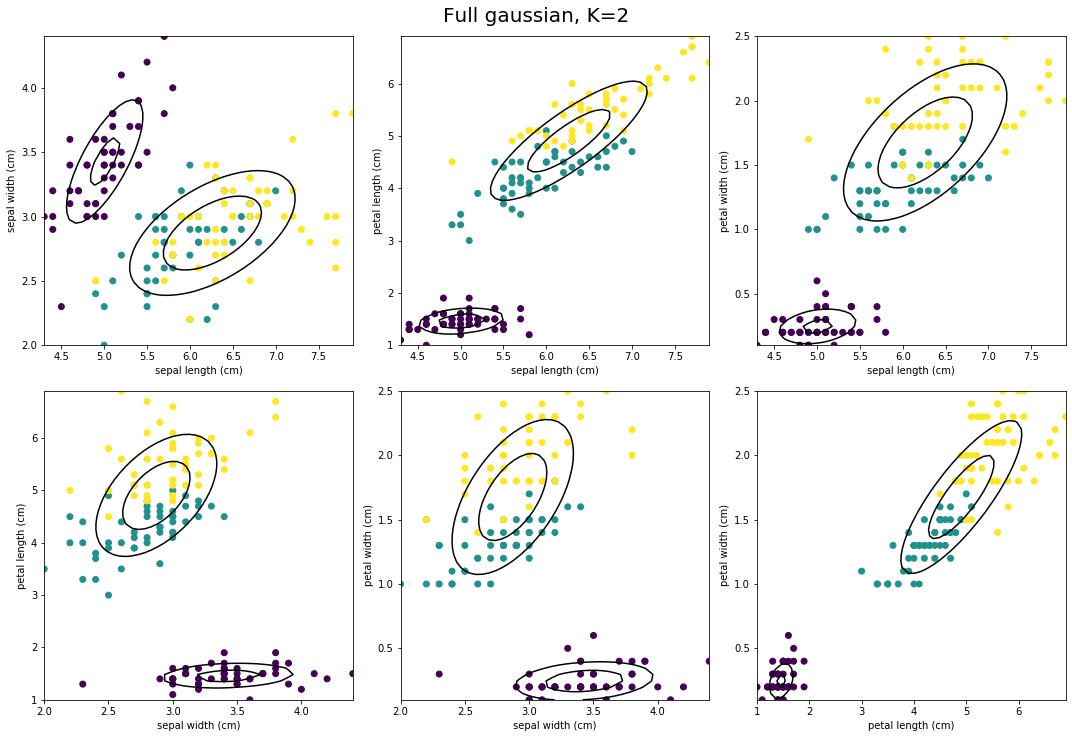

In [308]:
from sklearn import datasets
iris = datasets.load_iris()
K = 2
p, m, D = EM(iris.data,K=K,mode='full')
title = 'Full gaussian, K='+str(K)
fig = plot_all_projections(p,m,D,title=title)
fig.savefig('Full_gaussian_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

#### Full gaussians, K=3

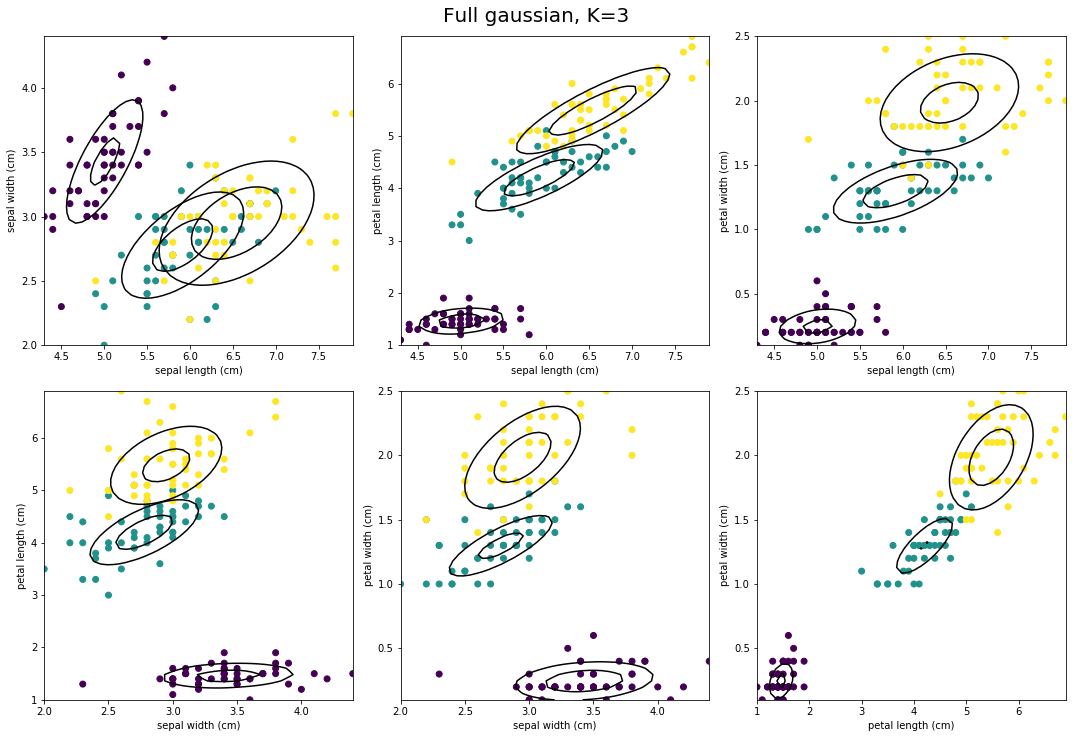

In [310]:
K = 3
p, m, D = EM(iris.data,K=K,mode='full')
title = 'Full gaussian, K='+str(K)
fig = plot_all_projections(p,m,D,title=title)
fig.savefig('Full_gaussian_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

#### Full gaussians, K=4

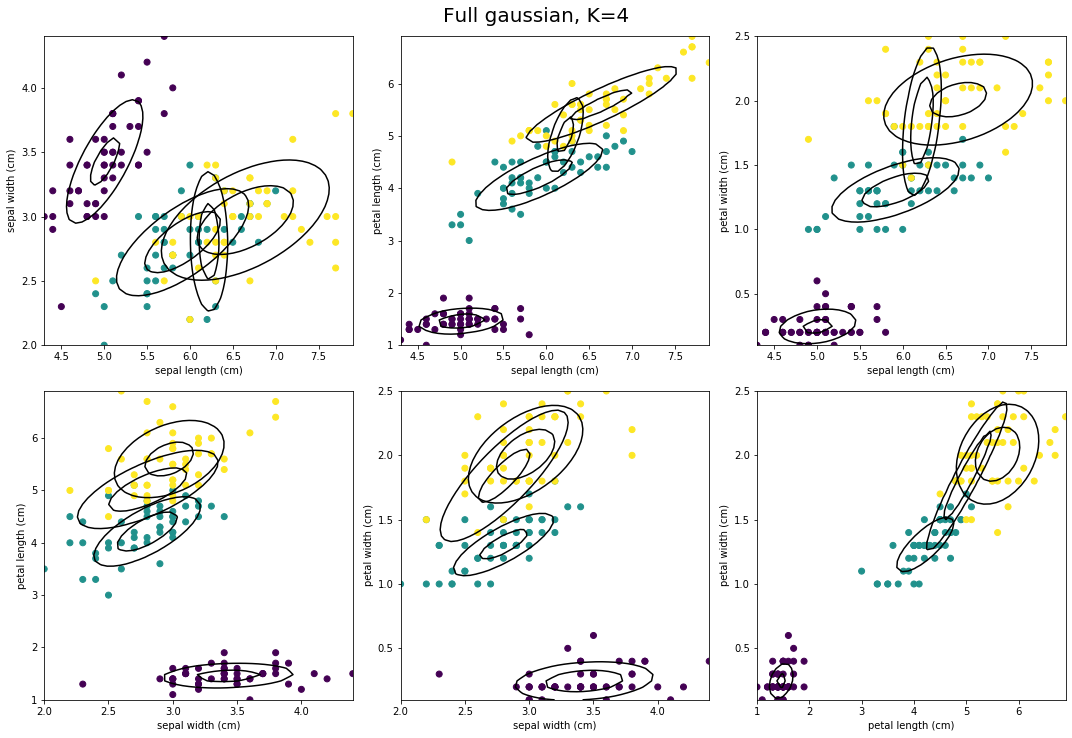

In [318]:
K = 4
p, m, D = EM(iris.data,K=K,mode='full')
title = 'Full gaussian, K='+str(K)
fig = plot_all_projections(p,m,D,title=title)
fig.savefig('Full_gaussian_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

#### Diagonal gaussians, K=2

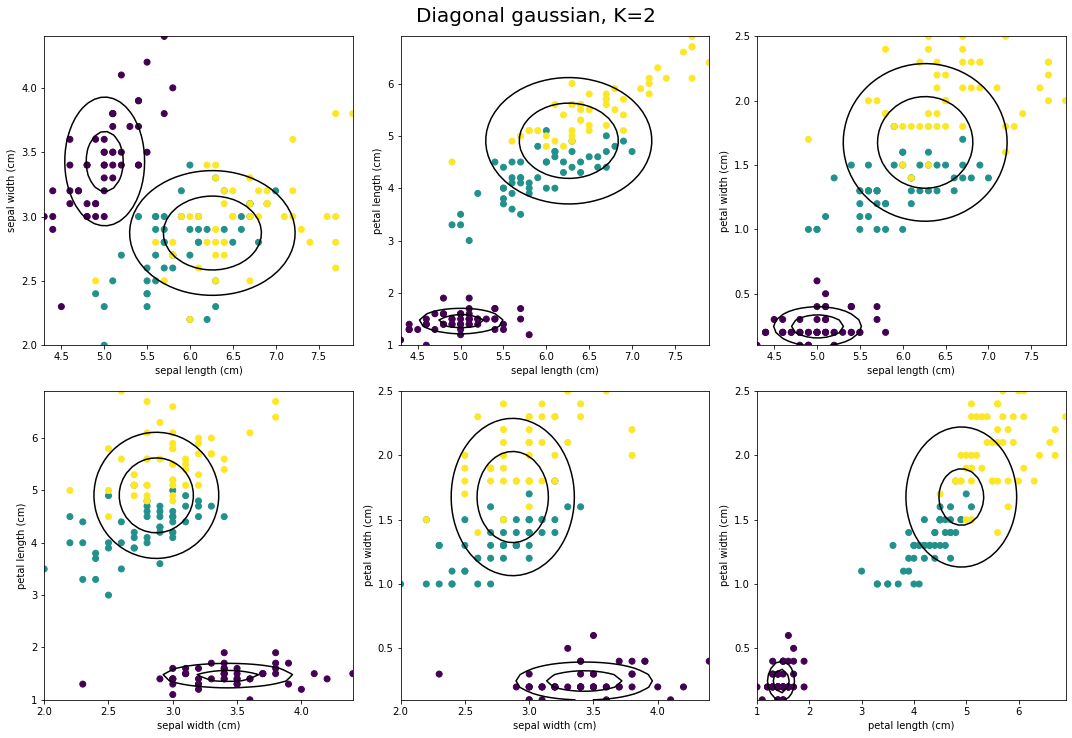

In [319]:
K = 2
p, m, D = EM(iris.data,K=K,mode='diagonal')
title = 'Diagonal gaussian, K='+str(K)
fig = plot_all_projections(p,m,D,title=title)
fig.savefig('diag_gaussian_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

#### Diagonal gaussians, K=3

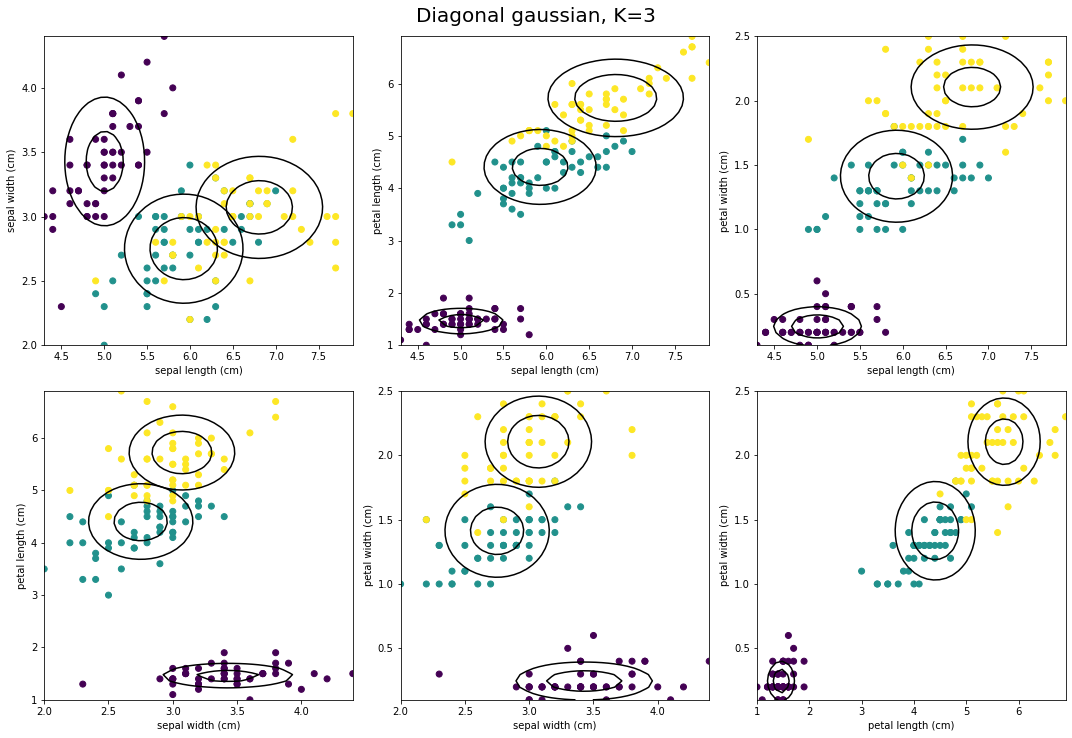

In [320]:
K = 3
p, m, D = EM(iris.data,K=K,mode='diagonal')
title = 'Diagonal gaussian, K='+str(K)
fig = plot_all_projections(p,m,D,title=title)
fig.savefig('diag_gaussian_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

#### Diagonal gaussians, K=4

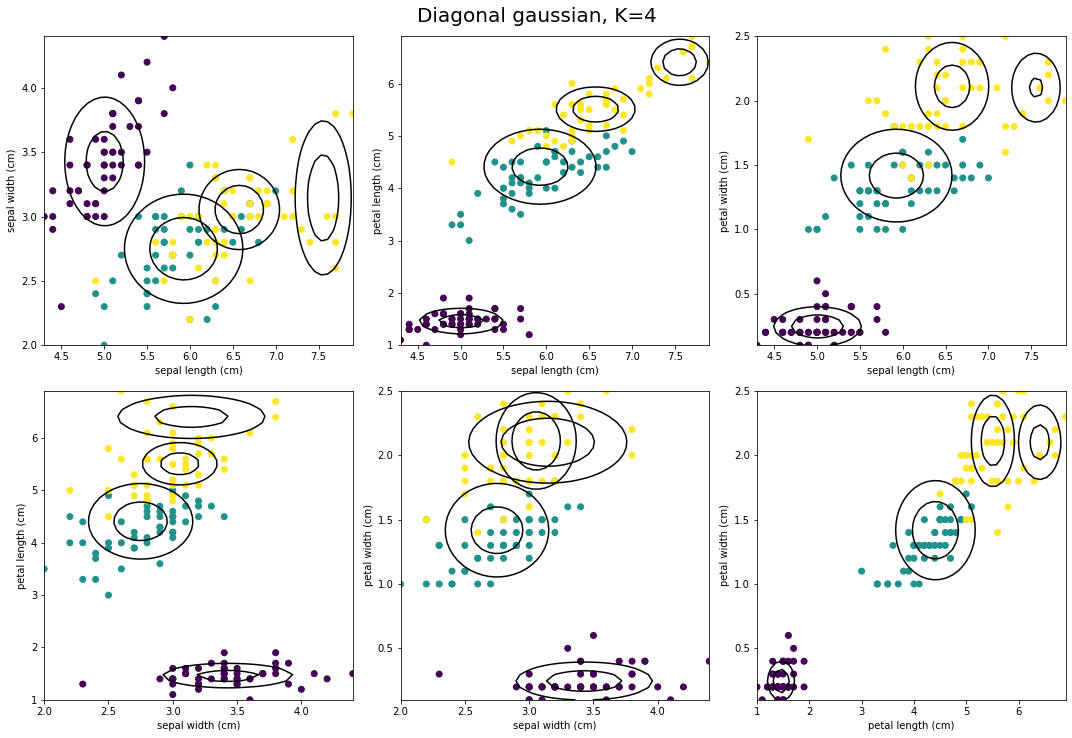

In [321]:
K = 4
p, m, D = EM(iris.data,K=K,mode='diagonal')
title = 'Diagonal gaussian, K='+str(K)
fig = plot_all_projections(p,m,D,title=title)
fig.savefig('diag_gaussian_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

#### KMeans, K = 2

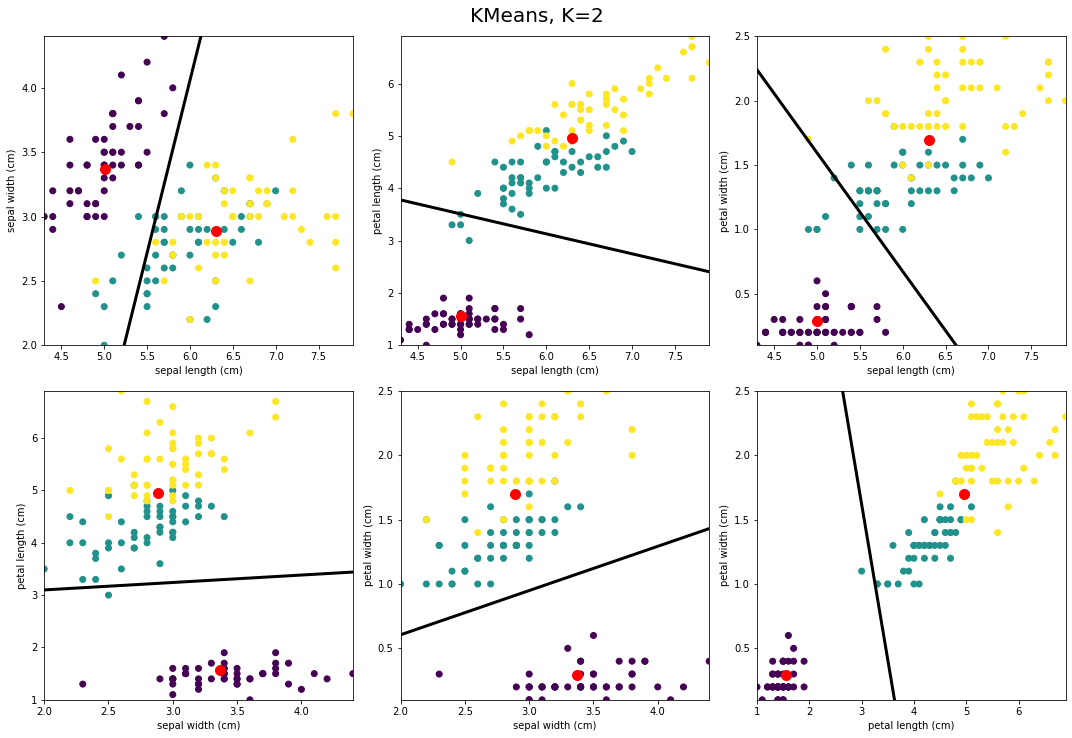

In [448]:
K = 2
m = KMeans(iris.data,K=K)
title = 'KMeans, K='+str(K)
fig = plot_all_projections(m=m,title=title,mode='KMeans')
fig.savefig('kmeans_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

#### KMeans, K=3

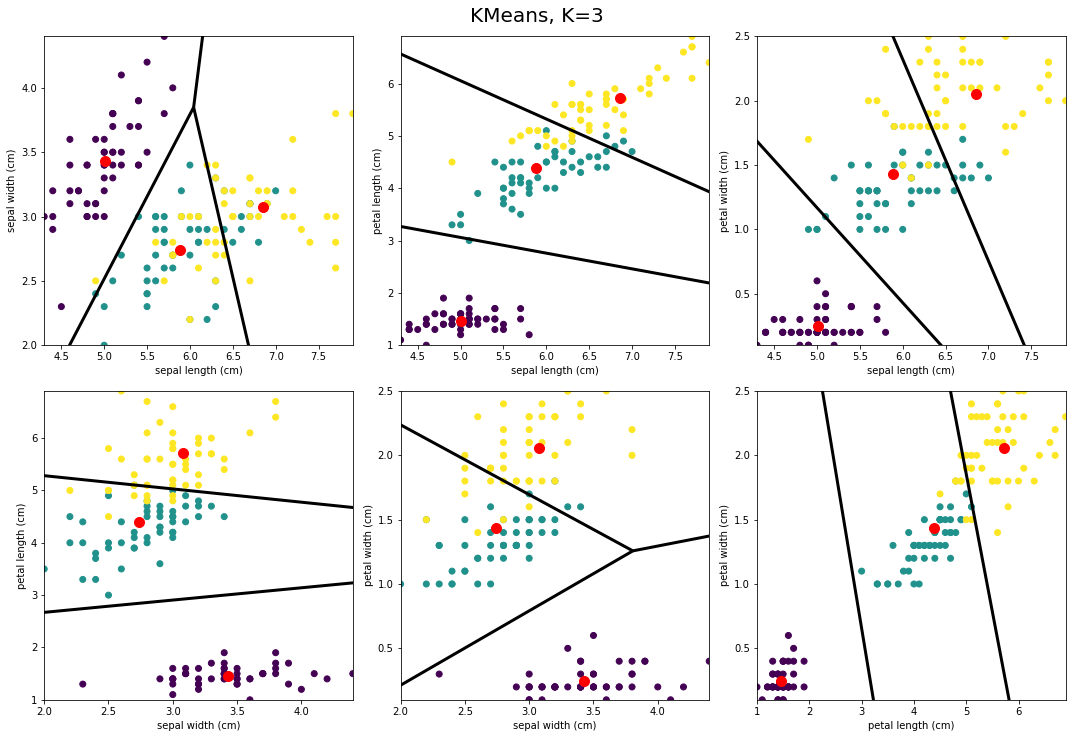

In [455]:
K = 3
m = KMeans(iris.data,K=K)
title = 'KMeans, K='+str(K)
fig = plot_all_projections(m=m,title=title,mode='KMeans')
fig.savefig('kmeans_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

#### KMeans, K=4

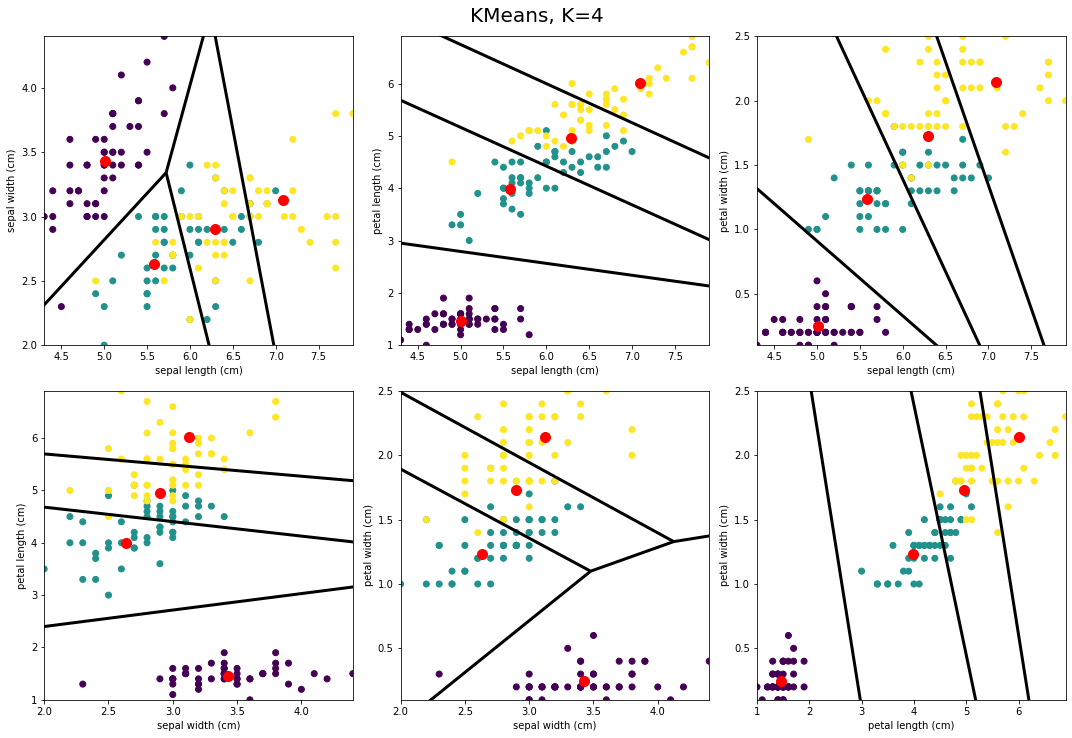

In [452]:
K = 4
m = KMeans(iris.data,K=K)
title = 'KMeans, K='+str(K)
fig = plot_all_projections(m=m,title=title,mode='KMeans')
fig.savefig('kmeans_'+str(K)+'.png',dpi=100,bbox_inches = "tight")

### 1.4 Drawbacks of KMeans

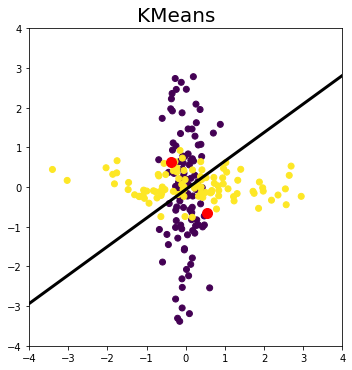

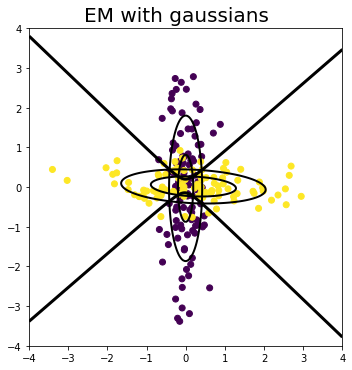

In [110]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import Voronoi, voronoi_plot_2d

# adaption of the above plot routine
def plot(data, target, p=None, m=None, D=None, mode='gaussians', title=''):
    """Plots the dataset X on all pairs of axes and overlays the estimated distributions"""
    dim = 2
    if m is not None:
        K = m.shape[0]
    fig = plt.figure(figsize=(5,5))
    fig.suptitle(title,fontsize=20,va='top',y=1.02)
    plot_num = 1
    ax = fig.add_subplot(1,1,1)
    xmin = -4#min(data[:,0].min(),data[:,0].min())
    xmax = 4#max(data[:,0].max(),data[:,0].max())
    ymin = -4#min(data[:,1].min(),data[:,1].min())
    ymax = 4#max(data[:,1].max(),data[:,1].max())
    ax.scatter(data[:,0],data[:,1],c=target)
    if mode=='gaussians':
        X = np.linspace(xmin, xmax, 500)
        Y = np.linspace(ymin, ymax, 500)
        X, Y = np.meshgrid(X, Y)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X; pos[:, :, 1] = Y
        for k in range(K):
            Z = multivariate_normal(m[k],D[k]).pdf(pos)
            ax.contour(X,Y,Z,levels=2,colors='k',linewidths=2)
        Z1 = multivariate_normal(m[0],D[0]).pdf(pos)
        Z2 = multivariate_normal(m[1],D[1]).pdf(pos)
        Z = Z1-Z2
        ax.contour(X,Y,Z,levels=[0],colors='k',linewidths=3)
    elif mode=='KMeans':
        # Voronoi diagrams with estimated means
        # Workaround to get the Voronoi package working.
        # Adding points far away that will not influence our region of interest
        vor_points = np.zeros(shape=(K+4,2))
        vor_points[0:K,:] = m
        far_away = 100
        vor_points[K,:] = [xmin-far_away,ymin-far_away]
        vor_points[K+1,:] = [xmin-far_away,ymax+far_away]
        vor_points[K+2,:] = [xmax+far_away,ymin-far_away]
        vor_points[K+3,:] = [xmax+far_away,ymax+far_away]
        vor = Voronoi(vor_points)
        voronoi_plot_2d(vor,ax=ax,show_points=False,show_vertices=False,line_width=3)
        ax.scatter(m[:,0],m[:,1],c='r',s=100)

    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    fig.tight_layout()
    return fig



# Data generation for an example where KMeans finds correct means but performs poorly at classification
#ms = [[-2,0],[0,3]]
#Ds = [[[0.1,0],[0,2]], [[0.4,0],[0,0.05]]]
ms = [[0,0],[0,0]]
Ds = [[[0.1,0],[0,2]], [[2,0],[0,0.1]]]
n_samples = 100
X = np.empty(shape=(len(ms)*n_samples,2))
target = []
for i in range(len(ms)):
    X[i*n_samples:(i+1)*n_samples,:] = multivariate_normal.rvs(mean=ms[i], cov=Ds[i], size=n_samples)
    target += [i]*n_samples
X = np.array(X)
target = np.array(target)

m = KMeans(X,2,iterations=30)
ps,ms,Ds = EM(X,2,mode='full',iterations=30)
fig1 = plot(X, target, m = m, mode='KMeans',title='KMeans')
#fig1.savefig('./EM_KMeans_1.png',dpi=100,bbox_inches='tight')
fig2 = plot(X, target, p=ps, m=ms, D=Ds, mode='gaussians', title='EM with gaussians')
#fig2.savefig('./EM_KMeans_2.png',dpi=100,bbox_inches='tight')